# Deep Convolutional GAN (DCGAN) for Fashion-MNIST

This notebook demonstrates the implementation of a Deep Convolutional Generative Adversarial Network (DCGAN) using PyTorch. The goal is to train a GAN to generate realistic images of fashion items from the Fashion-MNIST dataset.

The notebook covers:
- Loading and preprocessing the Fashion-MNIST dataset.
- Defining the Generator and Discriminator network architectures based on the DCGAN guidelines.
- Setting up the loss function and optimizers for training.
- Implementing the training loop for the adversarial process.
- Visualizing real and generated images.
- Plotting the training losses for both the Generator and Discriminator.

By the end of this notebook, you will have a trained DCGAN model capable of generating new fashion images and an understanding of the training dynamics of GANs.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## GAN Architecture Explanation

Generative Adversarial Networks (GANs) consist of two neural networks competing against each other:

- **Generator (G):** Takes random noise as input and tries to generate realistic images.
- **Discriminator (D):** Tries to differentiate between real images (from dataset) and fake images (from generator).

They are trained simultaneously with opposing objectives — G tries to fool D, and D tries to correctly identify real vs fake. This adversarial process improves generated image quality over time.

DCGAN uses **convolutional layers** in both G and D, which help learn spatial features effectively, making it well-suited for image data.

In [4]:
# Parameters and Hyperparameters

batch_size = 128
image_size = 64        # Fashion-MNIST images will be resized to 64x64
nz = 100               # Size of latent vector (noise)
num_epochs = 20
lr = 0.0002
beta1 = 0.5            # Beta1 hyperparam for Adam optimizers
ngf = 64               # Generator feature map size
ndf = 64               # Discriminator feature map size

In [6]:
transform = transforms.Compose([transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))])
# Load dataset
dataset = datasets.FashionMNIST(root='./data',
                                train=True,
                                transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 308kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.95MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.6MB/s]


In [10]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc=1):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is latent vector Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # state size: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # state size: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # state size: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # state size: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # output size: (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


In [11]:
class Discriminator(nn.Module):
    def __init__(self, ndf, nc=1):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)


In [12]:
# Initialize models
netG = Generator(nz, ngf).to(device)
netD = Discriminator(ndf).to(device)

# Loss function and fixed noise for visualization
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

In [13]:
# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [14]:
# Helper function to show images
def show_images(images, title=None):
    images = images / 2 + 0.5  # Denormalize from [-1,1] to [0,1]
    npimg = images.numpy()
    plt.figure(figsize=(8,8))
    plt.axis('off')
    if title:
        plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


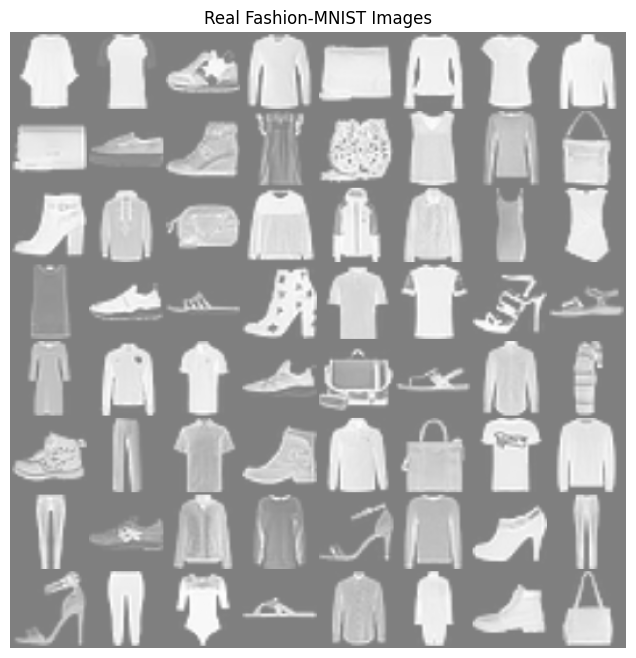

In [15]:
# Visualize real images before training
real_batch = next(iter(dataloader))
show_images(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True), "Real Fashion-MNIST Images")


## Training Process

The training of a Generative Adversarial Network (GAN) is an adversarial process where the Generator (G) and Discriminator (D) networks are trained simultaneously with opposing goals.

Here's a breakdown of the training loop:

1.  **Update Discriminator (D):**
    *   D is trained to distinguish between real and fake images.
    *   First, D is fed a batch of real images from the dataset. It calculates the loss based on how well it classifies these as "real".
    *   Next, G generates a batch of fake images from random noise. D is then fed these fake images and calculates the loss based on how well it classifies them as "fake".
    *   The gradients from both real and fake batches are combined, and D's weights are updated using an optimizer (like Adam) to minimize its total loss (maximize its ability to distinguish real from fake).

2.  **Update Generator (G):**
    *   G is trained to produce images that are realistic enough to fool D.
    *   G generates a batch of fake images from random noise.
    *   These fake images are then fed into D, but this time, G's loss is calculated based on how well D is *fooled* into classifying these fake images as "real".
    *   The gradients are calculated with respect to G's weights, and G's weights are updated using an optimizer (like Adam) to minimize its loss (maximize its ability to fool D).

This process is repeated for a specified number of epochs. As training progresses, G gets better at generating realistic images, and D gets better at distinguishing between real and fake images. This adversarial competition drives both networks to improve.

The training loop in the provided code iterates through the dataloader for a set number of epochs. Inside the loop:
- The Discriminator is updated based on its performance on both real and generated images.
- The Generator is updated based on how well its generated images fool the Discriminator.
- Loss values for both networks are recorded periodically to track training progress.
- Generated images from a fixed noise vector are saved at the end of each epoch to visualize the generator's improvement over time.

In [16]:
# Training Loop
img_list = []
G_losses = []
D_losses = []

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):

        ############################
        # (1) Update Discriminator
        ############################
        netD.zero_grad()
        real_images = real_images.to(device)

        b_size = real_images.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # Forward pass real batch through discriminator
        output = netD(real_images)
        errD_real = criterion(output, label)
        errD_real.backward()

        # Generate fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(fake_label)

        output = netD(fake_images.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        ############################
        # (2) Update Generator
        ############################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost

        output = netD(fake_images)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        # Print stats every 100 batches
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {i}/{len(dataloader)} \
                  Loss D: {errD_real.item()+errD_fake.item():.4f}, Loss G: {errG.item():.4f}")

    # Save losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD_real.item() + errD_fake.item())

    # Save fake images for visualization
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))


Starting Training Loop...
Epoch [1/20] Batch 0/469                   Loss D: 1.3051, Loss G: 3.0900
Epoch [1/20] Batch 100/469                   Loss D: 0.0013, Loss G: 7.7691
Epoch [1/20] Batch 200/469                   Loss D: 0.0399, Loss G: 6.8973
Epoch [1/20] Batch 300/469                   Loss D: 1.2451, Loss G: 1.9093
Epoch [1/20] Batch 400/469                   Loss D: 1.2941, Loss G: 2.1543
Epoch [2/20] Batch 0/469                   Loss D: 0.5149, Loss G: 2.3060
Epoch [2/20] Batch 100/469                   Loss D: 0.7171, Loss G: 0.7472
Epoch [2/20] Batch 200/469                   Loss D: 0.8454, Loss G: 0.8891
Epoch [2/20] Batch 300/469                   Loss D: 0.6445, Loss G: 2.4764
Epoch [2/20] Batch 400/469                   Loss D: 1.0135, Loss G: 1.5399
Epoch [3/20] Batch 0/469                   Loss D: 1.0201, Loss G: 3.8790
Epoch [3/20] Batch 100/469                   Loss D: 0.4921, Loss G: 2.5845
Epoch [3/20] Batch 200/469                   Loss D: 0.5569, Loss G:

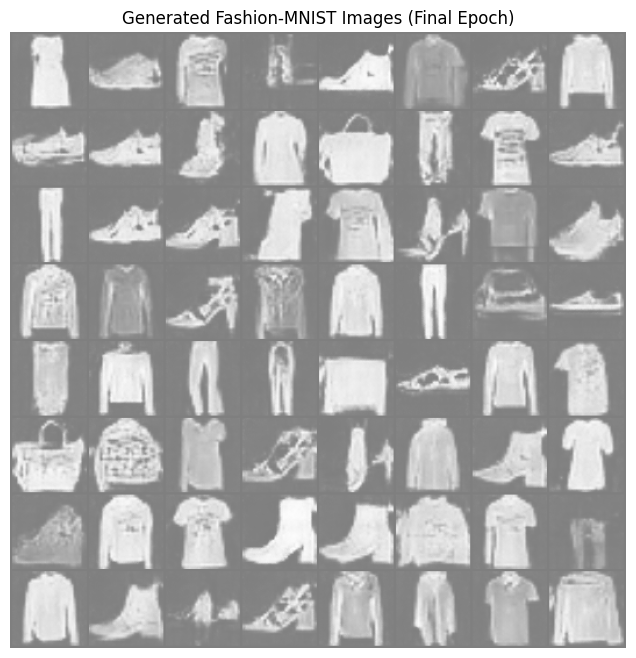

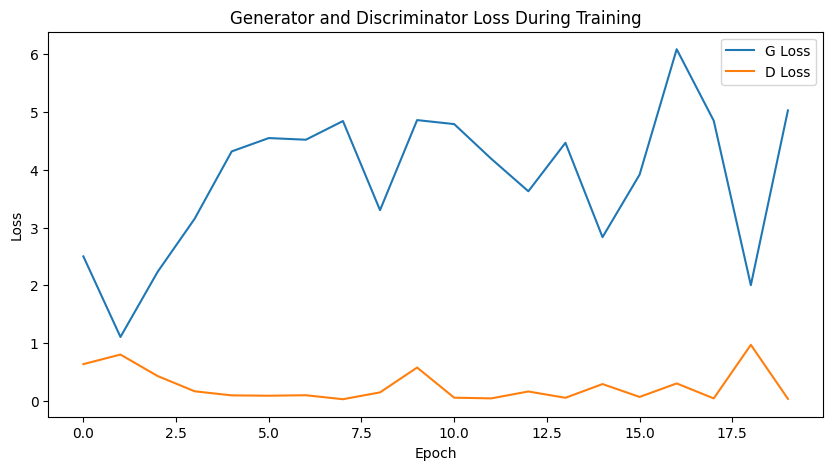

In [17]:
# Visualize generated images after training
show_images(img_list[-1], "Generated Fashion-MNIST Images (Final Epoch)")

# Plot training losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G Loss")
plt.plot(D_losses, label="D Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()